# Autoencoder simple

# Autoencoder simple

In [1]:
# import
import os
import glob
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from ctapipe.visualization import CameraDisplay
from ctapipe.instrument.camera import CameraGeometry
from ctapipe.io import EventSource 
from dl1_data_handler.image_mapper import ImageMapper
from ctapipe.instrument import SubarrayDescription
import matplotlib.pyplot as plt
import random
import h5py
import time
import sys

sys.path.append(os.path.abspath("../.."))
from utils import evaluate_threshold_classifier, plot_error_histograms, clean_image_improvement, plot_cost_curves

import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

geo = CameraGeometry.from_name("DigiCam")

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 64),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 16 * 5 * 5),
            nn.ReLU(),
            nn.Unflatten(1, (16, 5, 5)),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, output_padding=0),
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
def load_model(model_path):
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Créer le modèle avec la bonne dimension
    model = AE()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Epochs d'entraînement: {checkpoint['epochs']}")
    print(f"Loss finale (train): {checkpoint['train_loss_history'][-1]:.6f}")
    print(f"Loss finale (val): {checkpoint['val_loss_history'][-1]:.6f}")
    
    return model, checkpoint


timestamp = "20251228_114345"

model_path = f"autoencoder_{timestamp}.pth"
csv_protons_path = f"errors_protons_{timestamp}.csv"
csv_protons_energy_path = f"energies_protons_{timestamp}.csv"
csv_gammas_path = f"errors_gammas_{timestamp}.csv"
csv_gammas_energy_path = f"energies_gammas_{timestamp}.csv"

model, checkpoint = load_model(model_path)

Using device: cpu


/home/user/miniforge3/envs/ctlearn/lib/python3.10/site-packages/ctapipe/instrument/camera/geometry.py:616: FromNameWarning: .from_name uses pre-defined data that is likely different from the data being analyzed. Access instrument information via the SubarrayDescription instead.
  warn_from_name()


Modèle chargé depuis: autoencoder_20251228_114345.pth
Epochs d'entraînement: 10
Loss finale (train): 0.001211
Loss finale (val): 0.001225


In [3]:
def load_data(folder_path, max_events=None):
    telescopes = ["tel_001", "tel_002"]
    images_list = []
    masks_list = []
    peaks_list = []
    true_energy_list = []

    file_list = glob.glob(os.path.join(folder_path, "*.h5"))
    random.seed(42)
    random.shuffle(file_list)
    print(f"Found {len(file_list)} files", flush=True)

    for file_idx, file_path in enumerate(file_list, 1):
        print(f"Processing file {file_idx}/{len(file_list)}", flush=True)
        with h5py.File(file_path, "r") as f:
            
            ds_energy = f["simulation/event/subarray/shower"][:]
            energy_by_event = {
                row["event_id"]: row["true_energy"]
                for row in ds_energy
            }

            for tel in telescopes:
                ds_image = f[f"dl1/event/telescope/images/{tel}"][:]
                ds_params = f[f"dl1/event/telescope/parameters/{tel}"][:]

                n_events = ds_image.shape[0]

                for i in range(n_events):

                    if np.isnan(ds_params[i]["hillas_intensity"]):
                        continue

                    event_id = ds_params[i]["event_id"]
                    true_energy = energy_by_event[event_id]

                    images_list.append(ds_image[i]["image"].astype(np.float32))
                    peaks_list.append(ds_image[i]["peak_time"].astype(np.float32))
                    masks_list.append(ds_image[i]["image_mask"].astype(bool))
                    true_energy_list.append(true_energy.astype(np.float32))

                    if max_events is not None and len(images_list) >= max_events:
                        return images_list, masks_list, peaks_list, true_energy_list

    return images_list, masks_list, peaks_list, true_energy_list

class TelescopeDataset(Dataset):
    def __init__(self, folder_path, mapper, max_events=None):

        self.folder_path = folder_path
        self.images = []
        self.masks = []
        self.originals = []
        self.true_energies = []
        self.mapper = mapper

        start_total = time.time()
        images, masks, peaks, true_energies = load_data(folder_path, max_events=max_events)
        self.true_energies = true_energies
        print(f"Loaded {len(images)} events.", flush=True)
        print("Applying preprocessing...", flush=True)

        self._build_dataset(images, masks, peaks)

        end_total = time.time()
        print(f"Total loading time: {end_total - start_total:.2f} seconds", flush=True)
        print(f"Total events loaded: {len(self.images)}", flush=True)

        self.image_shape = self.images[0].shape

    def _build_dataset(self, images, masks, peaks):
        for image, msk, pk in zip(images, masks, peaks):

            # Preprocess the image
            img = np.clip(image, 0, None)
            img = self.mapper.map_image(img.reshape(-1, 1))
            img = img / (np.max(img) + 1e-8)

            self.images.append(img)
            self.masks.append(msk)

            self.originals.append(image)
    
    def get_true_energies(self):
        return self.true_energies

    def get_originals(self):
        return self.originals
                                                          
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = torch.tensor(img, dtype=torch.float32)
        img = img.permute(2, 0, 1)
        return img

In [4]:
epochs = checkpoint['epochs']
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']

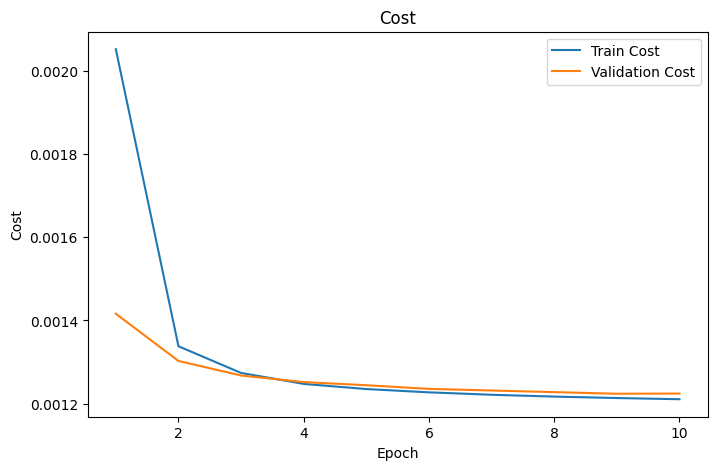

In [5]:
plot_cost_curves(train_loss_history, val_loss_history, epochs)

In [6]:
df_protons = pd.read_csv(csv_protons_path)
df_gammas = pd.read_csv(csv_gammas_path)
df_protons_energy = pd.read_csv(csv_protons_energy_path)
df_gammas_energy = pd.read_csv(csv_gammas_energy_path)

err_protons = df_protons["error"].to_numpy()
err_gammas = df_gammas["error"].to_numpy()
energy_protons = df_protons_energy["true_energy"].to_numpy()
energy_gammas = df_gammas_energy["true_energy"].to_numpy()

print("MSE protons:", np.median(err_protons))
print("MSE gammas:", np.median(err_gammas))

MSE protons: 0.0009275152700000001
MSE gammas: 0.00077785328


Protons:
  Mean   = 0.001215
  Median = 0.000928
  Std    = 0.000949

Gammas:
  Mean   = 0.001062
  Median = 0.000778
  Std    = 0.000843



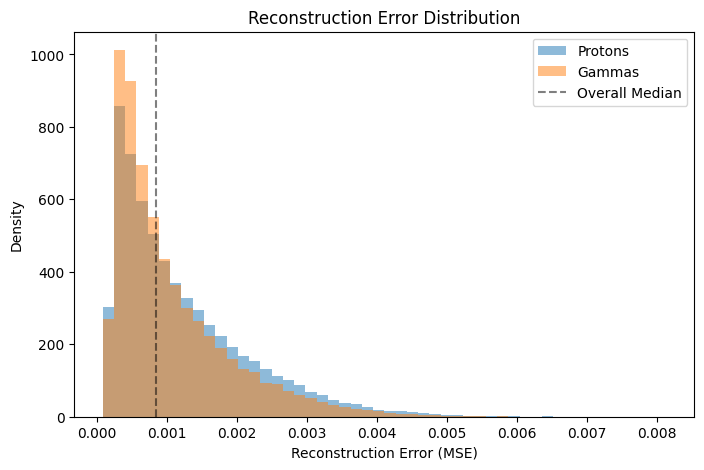

Using threshold: 0.000852684275


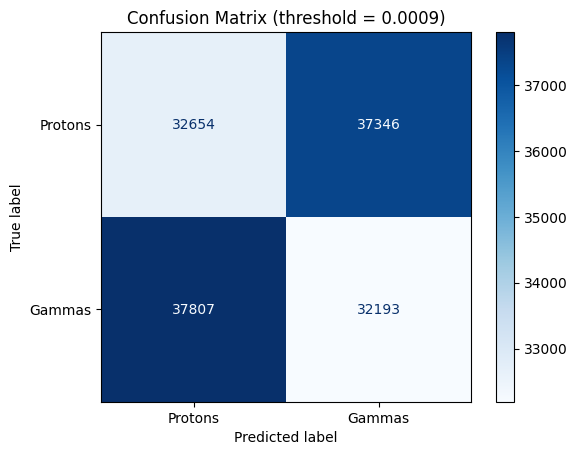


Classification Report:
              precision    recall  f1-score   support

     Protons       0.46      0.47      0.46     70000
      Gammas       0.46      0.46      0.46     70000

    accuracy                           0.46    140000
   macro avg       0.46      0.46      0.46    140000
weighted avg       0.46      0.46      0.46    140000



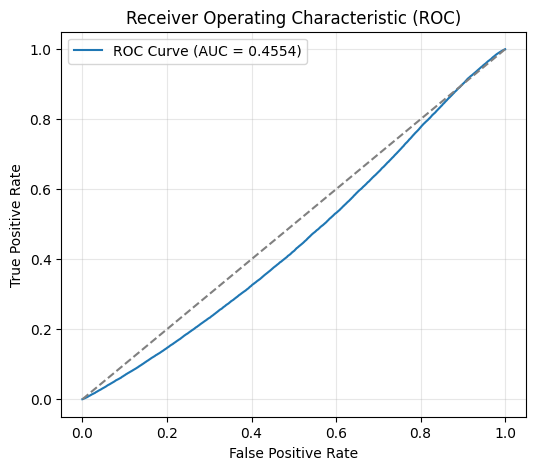

In [7]:
plot_error_histograms(err_protons, err_gammas)

threshold = (np.median(err_protons) + np.median(err_gammas)) / 2

y_true, y_pred, cm = evaluate_threshold_classifier(err_protons, err_gammas, threshold)

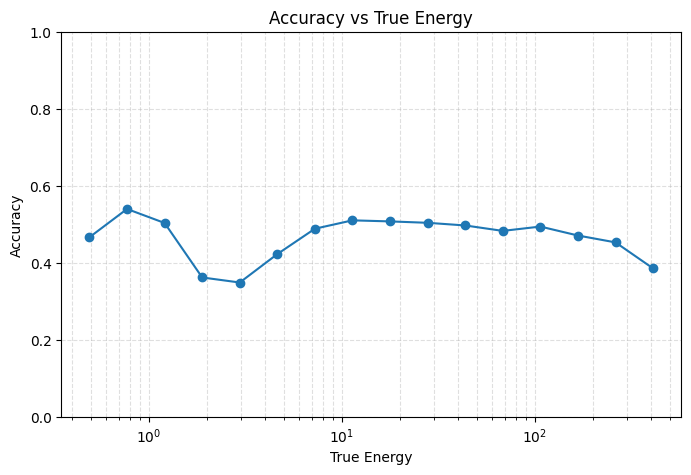

In [8]:
y_true_energy = np.concatenate([energy_protons, energy_gammas])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
energies = np.array(y_true_energy)

bins = np.logspace(np.log10(energies.min()), np.log10(energies.max()), 20)
bin_indices = np.digitize(energies, bins)

accuracies = []
bin_centers = []

MIN_EVENTS = 500

for b in range(1, len(bins)):
    idx = bin_indices == b
    n_events = idx.sum()

    if n_events < MIN_EVENTS:
        continue

    acc = np.mean(y_true[idx] == y_pred[idx])
    accuracies.append(acc)
    bin_centers.append((bins[b] + bins[b-1]) / 2)

plt.figure(figsize=(8,5))
plt.plot(bin_centers, accuracies, marker="o")
plt.xscale("log")
plt.xlabel("True Energy")
plt.ylabel("Accuracy")
plt.title("Accuracy vs True Energy")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.ylim(0, 1)
plt.show()


In [9]:
def reconstruct_dataset(model, dataset, batch_size=16):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    originals = []
    normalized = []
    reconstructed = []

    with torch.no_grad():
        for images in dataloader:   
            images = images.to(device)

            outputs = model(images)

            normalized.append(images.cpu())
            reconstructed.append(outputs.cpu())

    originals = dataset.get_originals()
    normalized = torch.cat(normalized, dim=0)
    reconstructed = torch.cat(reconstructed, dim=0)

    return originals, normalized, reconstructed

In [10]:
path_protons = "/home/user/TM/sst1m-ml-triggering/data_processing/calculus_data/data/work/analysis/MC/test/protons_diffuse/zenith_20deg"

file_list = glob.glob(os.path.join(path_protons, "*.h5"))
subarray = SubarrayDescription.read(file_list[0])
image_mapper = ImageMapper.from_name("ShiftingMapper", geometry=geo, subarray=subarray)
# Protons
dataset_protons = TelescopeDataset(path_protons, image_mapper, max_events=1500)
original_protons, norm_protons, rec_protons = reconstruct_dataset(model, dataset_protons)

# Gammas
path_gammas = "/home/user/TM/sst1m-ml-triggering/data_processing/calculus_data/data/work/analysis/MC/test/gammas_diffuse/zenith_20deg"
dataset_gammas = TelescopeDataset(path_gammas, image_mapper, max_events=1500)
original_gammas, norm_gammas, rec_gammas = reconstruct_dataset(model, dataset_gammas)

Found 5 files
Processing file 1/5
Processing file 2/5
Processing file 3/5
Loaded 1500 events.
Applying preprocessing...
Total loading time: 0.32 seconds
Total events loaded: 1500
Found 5 files
Processing file 1/5
Processing file 2/5
Processing file 3/5
Processing file 4/5
Processing file 5/5
Loaded 1500 events.
Applying preprocessing...
Total loading time: 0.33 seconds
Total events loaded: 1500


In [11]:
def display_reconstruction(orignal_norm, reconstructed_image, original_image, geometry):
    vmin = 0
    vmax = max(orignal_norm.max(), reconstructed_image.max())

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    disp0 = CameraDisplay(geometry, ax=axes[0, 0], title="Original Raw Image", image=original_image, cmap='viridis')
    disp0.add_colorbar(label="Photoelectrons (p.e.)")
    axes[0, 1].remove()

    axes[1, 0].pcolor(orignal_norm[0,:,:], cmap='viridis', vmin=vmin, vmax=vmax)
    axes[1, 0].set_title("Normalized Image (Square AE ShiftingMapper)")
    
    axes[1, 1].pcolor(reconstructed_image[0,:,:], cmap='viridis', vmin=vmin, vmax=vmax)
    axes[1, 1].set_title("Reconstructed Image (Square AE ShiftingMapper)")

    plt.show()

    print("Image min (original):", orignal_norm.min(), "max:", orignal_norm.max())
    print("Image min (reconstructed):", reconstructed_image.min(), "max:", reconstructed_image.max())

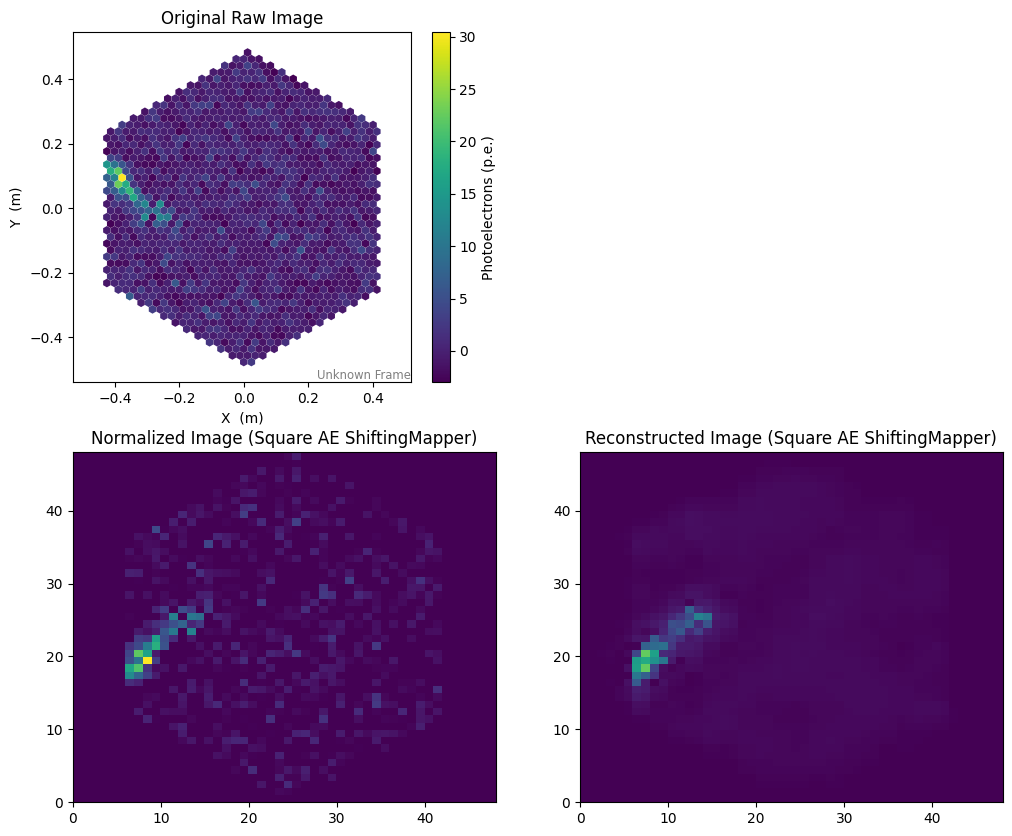

Image min (original): tensor(0.) max: tensor(1.)
Image min (reconstructed): tensor(-0.0641) max: tensor(0.7602)


In [12]:
idx = 9

display_reconstruction(norm_protons[idx], rec_protons[idx], original_protons[idx], geo)

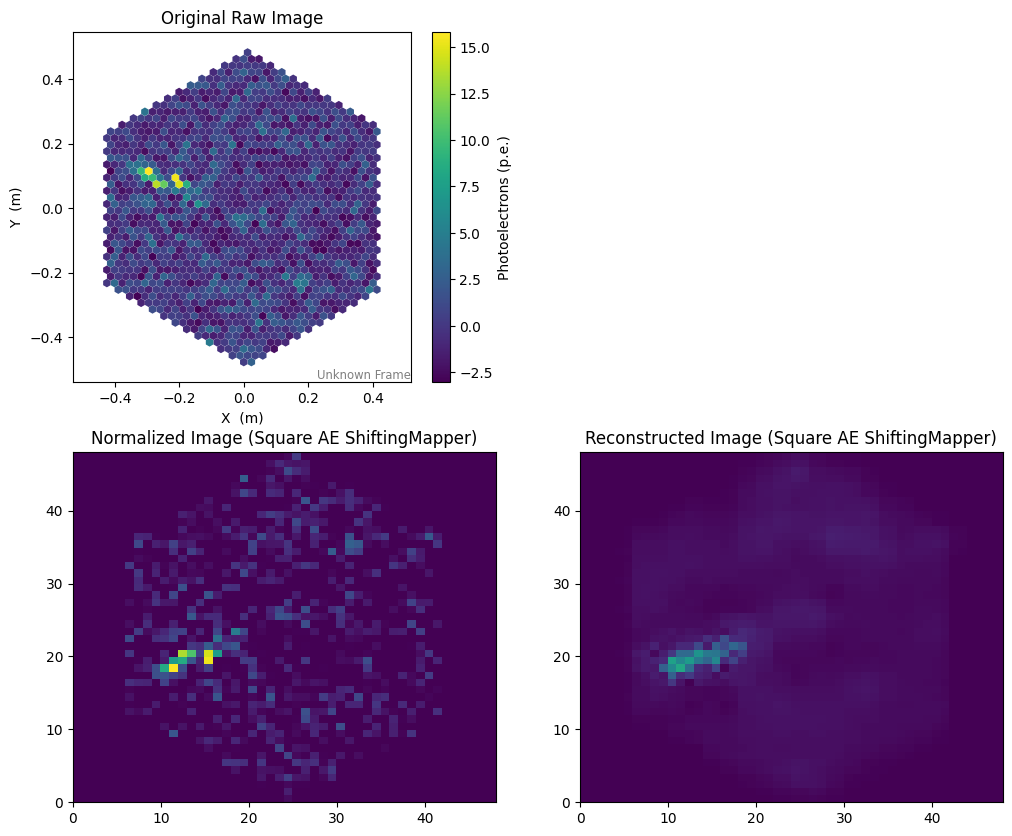

Image min (original): tensor(0.) max: tensor(1.)
Image min (reconstructed): tensor(-0.0010) max: tensor(0.5952)


In [13]:
idx = 3

display_reconstruction(norm_protons[idx], rec_protons[idx], original_protons[idx], geo)

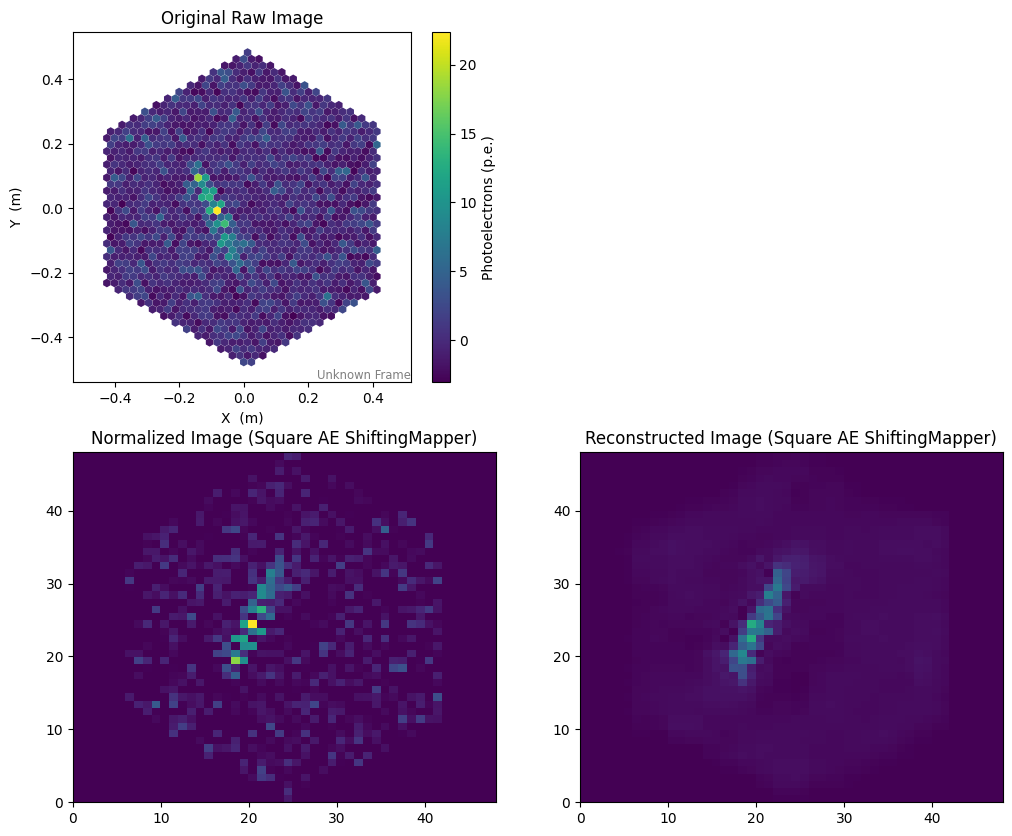

Image min (original): tensor(0.) max: tensor(1.)
Image min (reconstructed): tensor(-0.0150) max: tensor(0.6196)


In [14]:
idx = 13

display_reconstruction(norm_protons[idx], rec_protons[idx], original_protons[idx], geo)

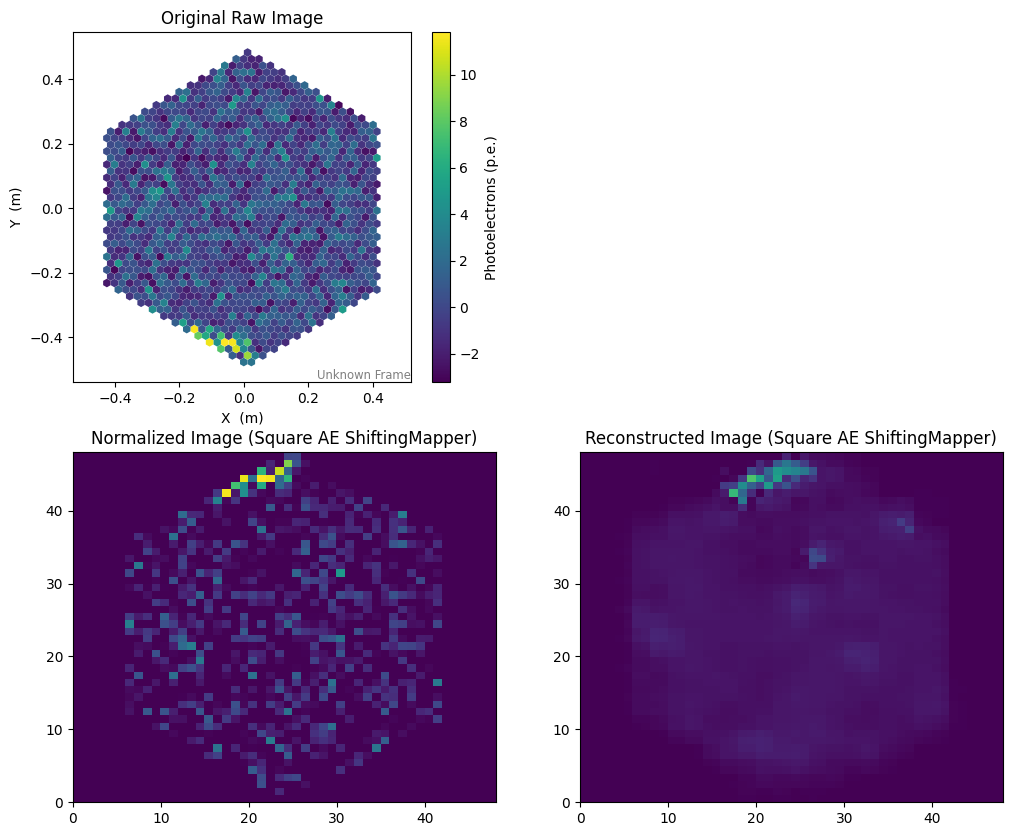

Image min (original): tensor(0.) max: tensor(1.)
Image min (reconstructed): tensor(-0.0896) max: tensor(0.7218)


In [15]:
idx = 4

display_reconstruction(norm_gammas[idx], rec_gammas[idx], original_gammas[idx], geo)

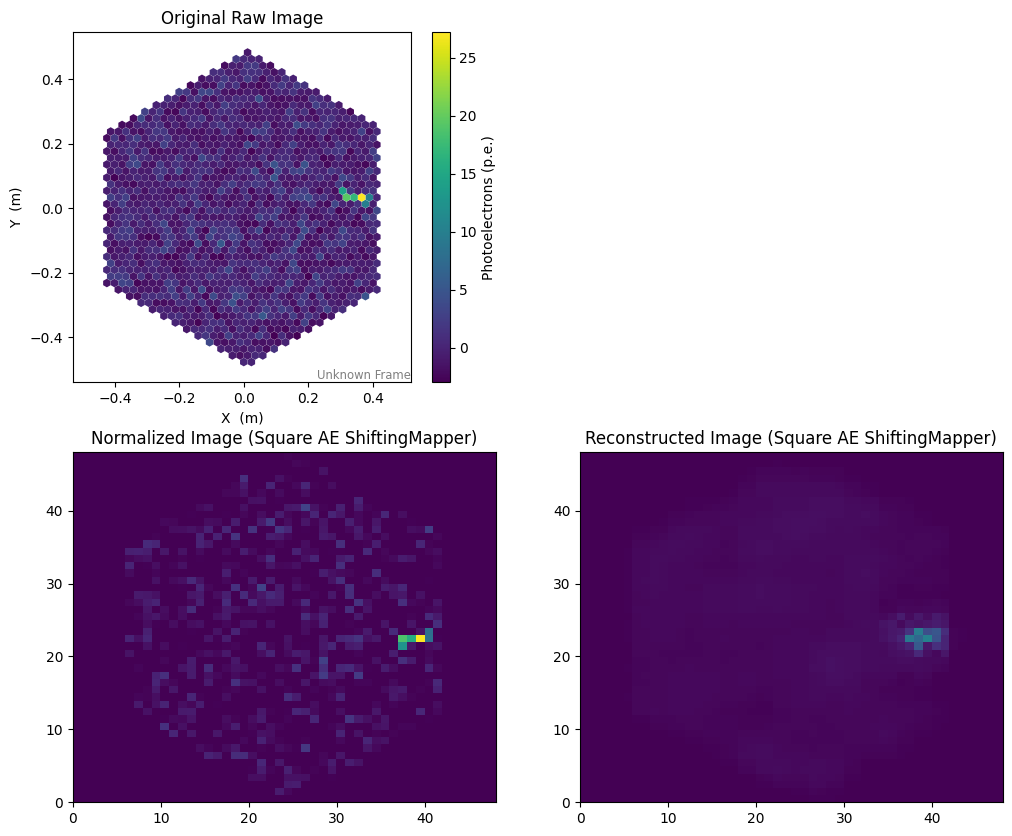

Image min (original): tensor(0.) max: tensor(1.)
Image min (reconstructed): tensor(-0.0005) max: tensor(0.4362)


In [16]:
idx = 9

display_reconstruction(norm_gammas[idx], rec_gammas[idx], original_gammas[idx], geo)

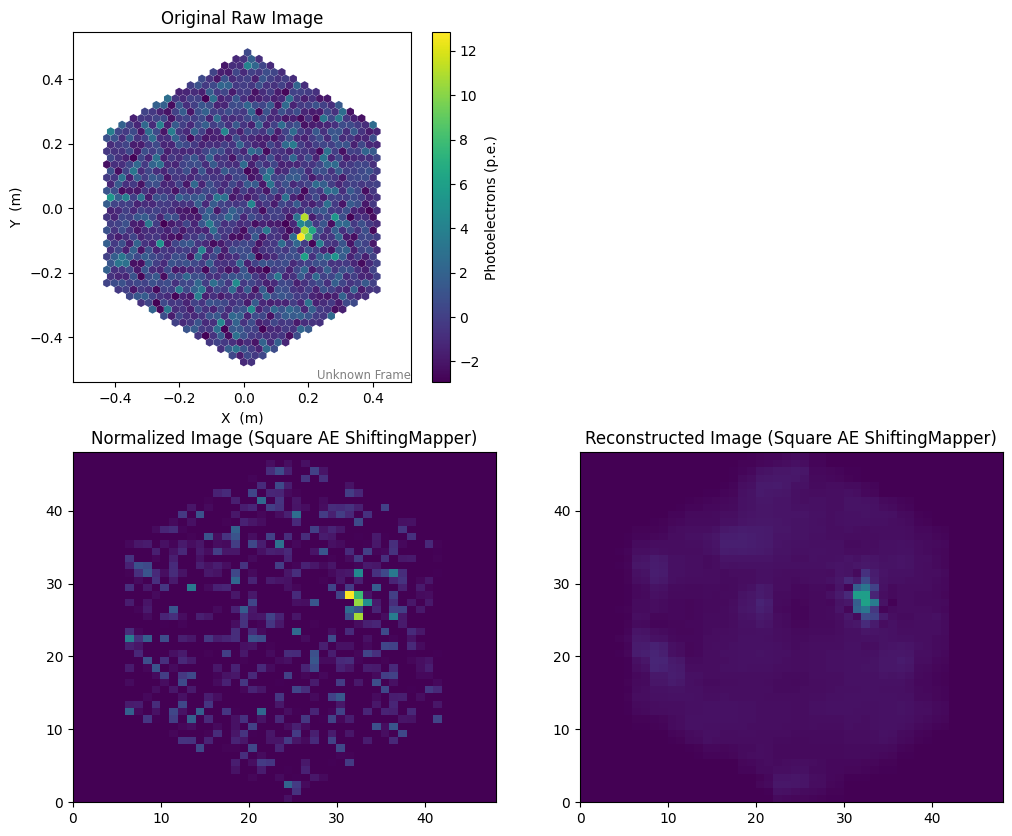

Image min (original): tensor(0.) max: tensor(1.)
Image min (reconstructed): tensor(-0.0039) max: tensor(0.5726)


In [17]:
idx = 19

display_reconstruction(norm_gammas[idx], rec_gammas[idx], original_gammas[idx], geo)